2. We import all library needed for training and visualisation

In [1]:
from os import path
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from copy import deepcopy

3. We clone the continualAI repo ta get an easy to use data loader for mnist

In [2]:
!git clone https://github.com/ContinualAI/colab.git continualai/colab

Cloning into 'continualai/colab'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 378 (delta 78), reused 64 (delta 62), pack-reused 258
Receiving objects: 100% (378/378), 26.97 MiB | 15.03 MiB/s, done.
Resolving deltas: 100% (198/198), done.


4. We import mnist and inialize it

In [3]:
from continualai.colab.scripts import mnist
mnist.init()

Download complete.
Save complete.


100%|██████████| 9912422/9912422 [00:00<00:00, 18024673.22it/s]


Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 477257.91it/s]


Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 4574301.75it/s]


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12863287.49it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



5. We can now load the data set and get training and testing data and labels

In [4]:
x_train, t_train, x_test, t_test = mnist.load()

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


6. We set a flag to use cuda for GPU acceleration and we fix the seed for reproducibility purpose

In [5]:
# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

7. Creation of a generator. We will use a GAN to achieve Generative Replay.

In [6]:
class Generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self):
        super(Generator, self).__init__()

        self.latent_dim = 1024
        self.input_height = 28
        self.input_width = 28
        self.input_dim = 62
        self.output_dim = 1

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, self.latent_dim),
            nn.BatchNorm1d(self.latent_dim),
            nn.ReLU(),
            nn.Linear(self.latent_dim, 128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.BatchNorm1d(128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Sigmoid(),
        )

        self.maxPool = nn.MaxPool2d((2, 2), stride=(2, 2))
        self.Sigmoid = nn.Sigmoid()
        self.apply(self.weights_init)

    def reinit(self):
      self.apply(self.weights_init)

    def forward(self, input):
        input = input.view(-1, self.input_dim)
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_height // 4), (self.input_width // 4))
        x = self.deconv(x)
        return x

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

7. Here is the Discriminator of our GAN

In [7]:
class Discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self):
        super(Discriminator, self).__init__()
        self.input_height = 28
        self.input_width = 28
        self.input_dim = 1
        self.output_dim = 1

        self.latent_dim = 1024

        shape = 128 * (self.input_height // 4) * (self.input_width // 4)

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(shape, self.latent_dim),
            nn.BatchNorm1d(self.latent_dim),
            nn.ReLU(),
            nn.Linear(self.latent_dim, self.output_dim),
            nn.Sigmoid(),
        )
        self.aux_linear = nn.Linear(shape, 10)
        self.softmax = nn.Softmax()
        self.apply(self.weights_init)

    def reinit(self):
      self.apply(self.weights_init)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(x.data.shape[0], 128 * (self.input_height // 4) * (self.input_width // 4))
        return self.fc(x)

분류기

In [8]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.input_height = 28
        self.input_width = 28
        self.input_dim = 1
        self.output_dim = 10
        self.batchsize = 64
        self.drop_prob = 0.3

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.batchsize, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(self.drop_prob),
            nn.Flatten())
        self.fc = nn.Linear(self.batchsize * self.input_height * self.input_width, self.output_dim)

    def forward(self, x):
        x = x.view(-1, 1, self.input_height, self.input_width)
        x = self.conv(x)
        x = self.fc(x)
        return x

    def predict(self, x_data):
        z=self.forward(x_data)
        return torch.argmax(z,axis=1) #가장 큰 인덱스 리턴

8. The function get_iter_dataset makes possible to load data from only one particular class. It will help to load data class by class.

In [9]:
# function to get digits from only one class
def get_iter_dataset(x_train, t_train, classe=None, nb_inc=None):
    if classe is not None:
        selected_indices = np.where((np.isin(t_train, np.arange(classe, classe + nb_inc))))[0]
        x = x_train[selected_indices]
        t = t_train[selected_indices]
        return x, t

### 9. The function "run_batch" train the Generator and Discriminator one a particular batch of data.

In [10]:
def run_batch(G, D, C, G_optimizer, D_optimizer, C_optimizer, x_, t_):
      x_ = x_.view((-1, 1, 28, 28))

      # y_real and y_fake are the label for fake and true data
      y_real_ = Variable(torch.ones(x_.size(0), 1))
      y_fake_ = Variable(torch.zeros(x_.size(0), 1))

      if use_cuda:
        y_real_, y_fake_ = y_real_.cuda(0), y_fake_.cuda(0)

      z_ = torch.rand((x_.size(0), z_dim))

      x_, z_ = Variable(x_), Variable(z_)

      if use_cuda:
        x_, z_, t_ = x_.cuda(0), z_.cuda(0), t_.cuda(0)

      # update D network
      D_optimizer.zero_grad()

      D_real = D(x_)
      D_real_loss = BCELoss(D_real, y_real_[:x_.size(0)])

      G_ = G(z_)
      D_fake = D(G_)
      D_fake_loss = BCELoss(D_fake, y_fake_[:x_.size(0)])

      D_loss = D_real_loss + D_fake_loss

      D_loss.backward()
      D_optimizer.step()

      # update G network
      G_optimizer.zero_grad()

      G_ = G(z_)
      D_fake = D(G_)
      G_loss = BCELoss(D_fake, y_real_[:x_.size(0)])

      G_loss.backward()
      G_optimizer.step()

      # update C

      C_optimizer.zero_grad()

      output = C(x_)

      C_loss = criterion(output, t_)

      C_loss.backward()
      C_optimizer.step()

      return output

In [11]:
#Declarations and Hyper-parameters

# Training hyper-parameter
nb_class = 10
nb_inc = 3
batch_size = 128
lr = 0.00005
z_dim = 62
epoch_number = 50
nb_samples = 10

G = Generator()
D = Discriminator()
C = Classifier()

# G and D are put in train mode
G.train()
D.train()
C.train()

if use_cuda:
  G.cuda(0)
  D.cuda(0)
  C.cuda(0)

# Use of Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)
C_optimizer = optim.Adam(C.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()
BCELoss = nn.BCELoss()

10. This function help to generate replayed data from the GAN use as memory (Gt-1)

In [12]:
def get_replay_with_label(generator, classifier, batchsize, task, nb_inc):
    images_list = []
    labels_list = []
    task_label = [[] for _ in range(task*nb_inc+nb_class % nb_inc)] # a list of lists that is used to keep track of the number of the number of generated samples for each label

    while True:
        if all(len(r) >= batchsize for r in task_label):
        # Checks whether there are at least 'batchsize' samples for each label in 'task_label'
        # The variable 'r' represents each innter list in 'task_label'
        # 'r' is a reference to one of the inner lists in 'task_label'
        # The loop continues until the condition is met for all inner lists, ensuring that each label has at least 'batchsize' samples.
            break
        z_ = Variable(torch.rand((batchsize, z_dim)))

        if use_cuda:
            z_ = z_.cuda(0)

        images = generator(z_)
        labels = classifier.predict(images)

        for i in range(len(labels)):
            label = labels[i]
            if len(task_label[label]) < batchsize:
                images_list.append(images[i].unsqueeze(0))
                labels_list.append(label.item())
                task_label[label].append(label.item())

    images = torch.cat(images_list, dim=0)
    labels = torch.tensor(labels_list)

    return images.cpu(), labels.cpu()

###Training Generator with Replay

After seeing what happend when training without Generative Replay, we can now see how efficient generative replay is in this setting.

tensor([0, 0, 1, 3, 2, 1, 2, 0, 3, 3], device='cuda:0')
tensor([2, 4, 5, 3, 3, 2, 4, 0, 2, 0], device='cuda:0')
tensor([0, 1, 0, 4, 3, 5, 1, 9, 6, 2], device='cuda:0')


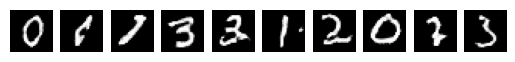

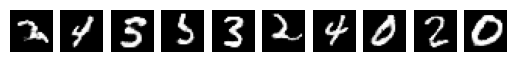

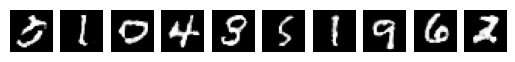

In [13]:
# We reinit D and G to not cheat
G.reinit()
D.reinit()

for task in range(nb_class//nb_inc):

  if task == 0:
    data, label = get_iter_dataset(x_train, t_train, classe=task*nb_inc, nb_inc=nb_inc + nb_class % nb_inc) # 0, 1, 2, 3
  else:
    data, label = get_iter_dataset(x_train, t_train, classe=task*nb_inc+ nb_class % nb_inc, nb_inc=nb_inc)
  nb_batch = int(len(data)/batch_size)

  for epoch in range(epoch_number):
    for index in range(nb_batch):
      x_ =torch.FloatTensor(data[index*batch_size:(index+1)*batch_size])
      t_ =torch.tensor(label[index*batch_size:(index+1)*batch_size])
      if task > 0 :
        # We concat a batch of previously learned data
        # the more there is past task more data need to be regenerate
        replay, re_label = get_replay_with_label(G_saved, C_saved, batch_size, task, nb_inc)
        x_=torch.cat((x_,replay),0)
        t_=torch.cat((t_,re_label),0)

      run_batch(G, D, C, G_optimizer, D_optimizer, C_optimizer, x_, t_)

  G_saved = deepcopy(G)
  C_saved = deepcopy(C)

  z_ = Variable(torch.rand((nb_samples, z_dim)))

  if use_cuda:
    z_ = z_.cuda(0)
  samples = G(z_).data
  samples = samples.cpu().numpy()
  #plt.plot(samples[0])

  f, axarr = plt.subplots(1,nb_samples)
  for j in range(nb_samples):
    axarr[j].imshow(samples[j, 0], cmap="gray")
  np.vectorize(lambda ax:ax.axis('off'))(axarr);

  samples_tensor = torch.FloatTensor(samples)
  if use_cuda:
    samples_tensor = samples_tensor.cuda()

  predictions = C.predict(samples_tensor)

  print(predictions)

학습한 거 사진 어떻게 나오나 + 라벨 보고 싶으면 아래 두 코드만 반복하면 됩니다!

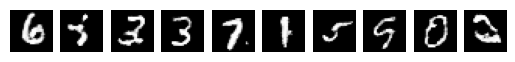

In [14]:
z_ = Variable(torch.rand((nb_samples, z_dim)))
if use_cuda:
  z_ = z_.cuda(0)
samples = G(z_).data
samples = samples.cpu().numpy()
#plt.plot(samples[0])

f, axarr = plt.subplots(1,nb_samples)
for j in range(nb_samples):
  axarr[j].imshow(samples[j, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

In [15]:
samples_tensor = torch.FloatTensor(samples)

samples_tensor = samples_tensor.view(-1, 1, 28, 28)

if use_cuda:
    samples_tensor = samples_tensor.cuda()

predictions = C.predict(samples_tensor)

print(predictions)

tensor([6, 5, 3, 3, 7, 1, 5, 5, 0, 2], device='cuda:0')


정확도

In [16]:
def test(model, x_test, y_test):

    x_test = torch.FloatTensor(x_test)
    y_test = torch.LongTensor(y_test)


    if use_cuda:
        x_test = x_test.cuda()
        y_test = y_test.cuda()

    prediction = model(x_test)
    predicted_classes = prediction.max(1)[1]
    correct_count = (predicted_classes == y_test).sum().item()
    cost = F.cross_entropy(prediction, y_test)

    print('Accuracy: {}% Cost: {:.6f}'.format(
        correct_count / len(y_test) * 100, cost.item()
    ))

In [17]:
test(C, x_test, t_test)

Accuracy: 97.27% Cost: 0.121129


비교용 분류기

In [18]:
class Classifier_test(nn.Module):
    def __init__(self):
        super(Classifier_test, self).__init__()

        self.input_height = 28
        self.input_width = 28
        self.input_dim = 1
        self.output_dim = 10
        self.batchsize = 64
        self.drop_prob = 0.3

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.batchsize, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(self.drop_prob),
            nn.Flatten())
        self.fc = nn.Linear(self.batchsize * self.input_height * self.input_width, self.output_dim)

    def forward(self, x):
        x = x.view(-1, 1, self.input_height, self.input_width)
        x = self.conv(x)
        x = self.fc(x)
        return x

    def predict(self, x_data):
        z=self.forward(x_data)
        return torch.argmax(z,axis=1) #가장 큰 인덱스 리턴

In [19]:
model_test = Classifier_test()
criterion_test = nn.CrossEntropyLoss()
C_optimizer_test = optim.Adam(model_test.parameters(), lr=lr)

In [20]:
x_train_t = torch.tensor(x_train, dtype=torch.float32)
t_train_t = torch.tensor(t_train, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(x_train_t, t_train_t)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)


In [ ]:
for epoch in range(epoch_number):
    model_test.train()
    for i, (inputs, labels) in enumerate(train_loader):
        C_optimizer_test.zero_grad()
        outputs = model_test(inputs)
        loss_t = criterion_test(outputs, labels)
        loss_t.backward()
        C_optimizer_test.step()

In [ ]:
def test_t(model, x_test, y_test):

    x_test = torch.FloatTensor(x_test)
    y_test = torch.LongTensor(y_test)

    prediction = model(x_test)
    predicted_classes = prediction.max(1)[1]
    correct_count = (predicted_classes == y_test).sum().item()
    cost = F.cross_entropy(prediction, y_test)

    print('Accuracy: {}% Cost: {:.6f}'.format(
        correct_count / len(y_test) * 100, cost.item()
    ))

In [ ]:
test_t(model_test, x_test, t_test)